In [1]:
import os
os.chdir('../')

## Imports

In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from src.utils import flatten, get_segments
from src.segmentation import ImobsSegmentation
from src.develop.feature_importance import ShapValues
from src.develop.cross_validation import CrossValidation
from src.train import ClassificationModel, TwoStepCalibration

# warnings
import warnings
warnings.filterwarnings('ignore')

## Data Collect

In [3]:
df_model = pd.read_csv("notebooks/outputs/df_model_2.csv")

df_model["dt_calendar"] = pd.to_datetime(df_model["dt_calendar"])
df_model = df_model[(df_model.dt_calendar >= "2020-01")]

print(df_model.shape)
df_model.head()

(9559, 25)


,dt_calendar,id_imobiliaria,lat_imob,long_imob,is_active,is_activated,is_commun_first_90days,is_debelado,is_debelado_first_4months,is_indemnified,...,rating_A,rating_B,rating_C,rating_D,rating_E,target,churn_rate,agg_activated_last_90days,agg_comun_last_90days,agg_churn_rate
8,2020-01-01,38,-20.31,-40.3,144.0,5,1.0,3,0.0,1,...,0.00,0.80,0.20,0.0,0.00,0,0.0,7.833333,0.021277,0.010334
9,2020-02-01,38,-20.31,-40.3,145.0,6,4.0,2,0.0,0,...,0.00,0.67,0.33,0.0,0.00,0,0.0,6.500000,0.128205,0.008791
10,2020-03-01,38,-20.31,-40.3,149.0,9,0.0,4,4.0,1,...,0.11,0.44,0.33,0.0,0.11,0,0.0,6.833333,0.121951,0.004878
11,2020-04-01,38,-20.31,-40.3,153.0,2,0.0,2,0.0,1,...,0.00,0.50,0.50,0.0,0.00,0,0.0,6.333333,0.131579,0.005263
12,2020-05-01,38,-20.31,-40.3,154.0,3,1.0,3,1.0,1,...,0.00,0.67,0.00,0.0,0.33,1,0.0,5.000000,0.200000,0.006667


## Model

### Instâncias

In [4]:
path = "notebooks/outputs/params_et_2.json"

In [5]:
with open(path, "r") as f:
    params_et = json.load(f)
    
params_lgbm =  {
    'metric': 'auc',
    'random_state': 5,
    'objective': 'binary',
    'max_depth': 3,
    'n_estimators': 500,
    'subsample': 0.4,
    'colsample_bytree': 0.5,
    'learning_rate': 0.01
}
parameters_lr = {
    'solver':'sag',
    'C': 1e6,
    'fit_intercept': True
}

In [6]:
lgbm = LGBMClassifier(**params_lgbm)
et = ExtraTreesClassifier(
    random_state=5, oob_score=True, bootstrap=True,
    **params_et
)
lr = LogisticRegression(**parameters_lr)

et_lr = TwoStepCalibration(et, lr)
lgbm_lr = TwoStepCalibration(lgbm, lr)

### Cross-Validation

In [7]:
et_cv = CrossValidation(df_model, et, roc_auc_score)
lgbm_cv = CrossValidation(df_model, lgbm, roc_auc_score)

In [8]:
et_cv.fit(from_="2021-12", to_="2022-05")

TRAINING UNTIL (2021-11) | VALIDATING FROM (2021-12) UNTIL (2022-05): (AUC=0.7445)
TRAINING UNTIL (2021-12) | VALIDATING FROM (2022-01) UNTIL (2022-05): (AUC=0.7404)
TRAINING UNTIL (2022-01) | VALIDATING FROM (2022-02) UNTIL (2022-05): (AUC=0.7029)
TRAINING UNTIL (2022-02) | VALIDATING FROM (2022-03) UNTIL (2022-05): (AUC=0.7148)
TRAINING UNTIL (2022-03) | VALIDATING FROM (2022-04) UNTIL (2022-05): (AUC=0.7049)
TRAINING UNTIL (2022-04) | VALIDATING FROM (2022-05) UNTIL (2022-05): (AUC=0.796)


0.7339

In [9]:
# lgbm_cv.fit(from_="2021-12", to_="2022-05")

### Treino e Teste

In [10]:
et_model = ClassificationModel(df_model, et_lr, roc_auc_score)

et_model.fit(cutoff_period="2022-05")
et_model.test_model(cutoff_period="2022-05")


TESTING ON (2022-05)


0.796

In [11]:
lgbm_model = ClassificationModel(df_model, lgbm_lr, roc_auc_score)

lgbm_model.fit(cutoff_period="2022-06")
lgbm_model.test_model(cutoff_period="2022-06")

TESTING ON (2022-06)


0.5526

##### Calibração

In [13]:
y_pred_et = et_lr.predict_proba(et_model.X_test)[:,1]

In [14]:
print(f"""
[Extra-Tree]
y_pred: {round(y_pred_et.sum(), 2)}
y_test: {et_model.y_test.sum()}
""")


[Extra-Tree]
y_pred: 17.45
y_test: 4.0



In [15]:
segmentation_df, segment_rates = get_segments(y_pred_et)
segment_rates

,mean,size
segments,,
A,0.025318,61
B,0.027218,77
C,0.030572,78
D,0.037618,80
E,0.085007,99


## Histórico para Segmentação

In [17]:
def segmentation_preds_hist(df, lr_model, cohorts):

    all_df_preds = []
    for cohort in cohorts:
        model = ClassificationModel(df, lr_model, roc_auc_score)

        model.fit(cutoff_period=cohort)
        model.test_model(cutoff_period=cohort)

        y_pred = lr_model.predict_proba(model.X_test)[:,1]

        df_ = df[df.dt_calendar == cohort][["dt_calendar", "id_imobiliaria"]]

        df_["predictions"] = y_pred
        df_["target"] = model.y_test

        ### Antiga segmentação apenas para fins comparativos #######
        segmentation_df, segment_rates = get_segments(y_pred)
        df_["old_segments"] =  np.array(segmentation_df["segments"])
        ############################################################

        all_df_preds.append(df_)

    df_preds = pd.concat(all_df_preds)
    df_preds.to_csv(f"notebooks/outputs/df_preds_2.csv", index=False)

In [18]:
segmentation_preds_hist(df_model, et_lr, [
    "2021-12", "2022-01", "2022-02", "2022-03", "2022-04", "2022-05"
    # "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11"

])

TESTING ON (2021-12)
TESTING ON (2022-01)
TESTING ON (2022-02)
TESTING ON (2022-03)
TESTING ON (2022-04)
TESTING ON (2022-05)


## Matriz de Correlação

In [76]:
# function to create a correlation matrix
def plot_corr(df, method, size=10):
    corr = df.corr(method=method)
    
    # generates a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    fig, ax = plt.subplots(figsize=(size, size))
    
    # custom colormap palette
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # draws the heatmap with the mask
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, annot_kws={"fontsize": 10},
                annot=True, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    # labels properties
    plt.xticks(range(len(corr.columns)), corr.columns, fontsize='11')
    plt.yticks(range(len(corr.columns)), corr.columns, fontsize='11')

In [77]:
features_corr = [
    "lat_imob",
    "long_imob",
    "is_activated",
    "rating_A",
    "rating_B",
    "rating_C",
    "rating_D",
    "rating_E",
    "churn_rate",
    "agg_comun_last_90days",
    "agg_deb_last_4months",
    "agg_exon_last_6months",
    "target"
]

In [78]:
train_df = et_model.X_train
train_df["target"] = et_model.y_train

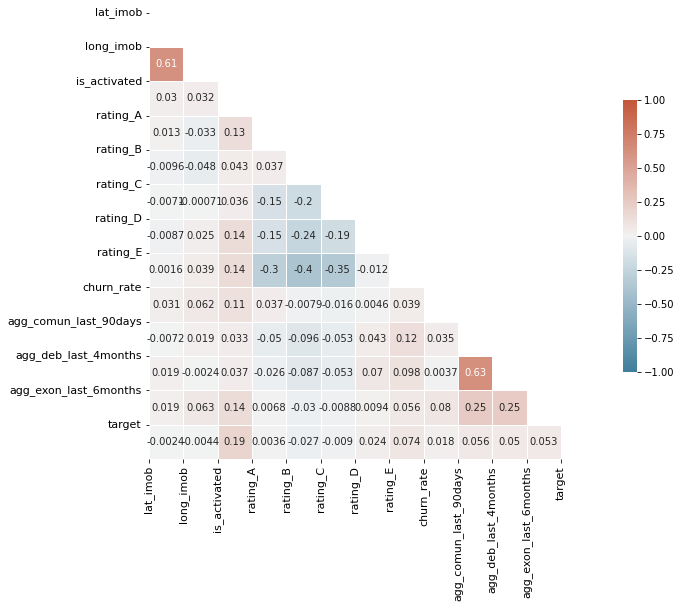

In [79]:
# creating a correlation plot to understand monotonic relations
plot_corr(
    train_df[features_corr],
    method='spearman'
)

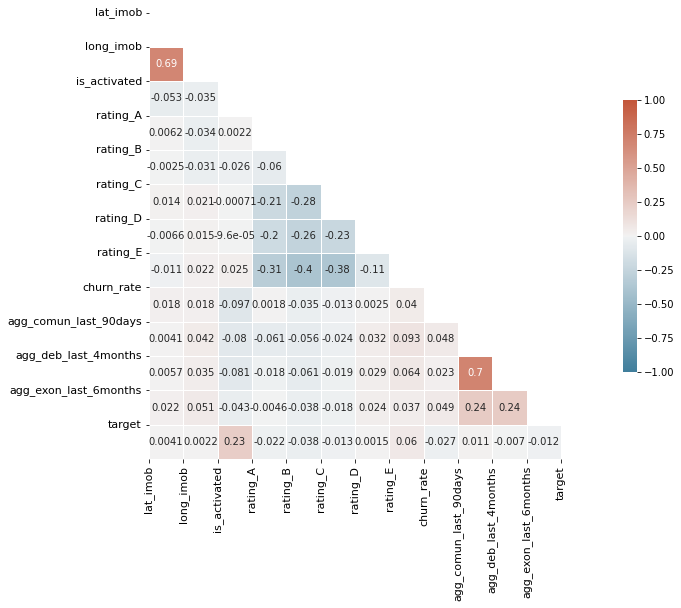

In [80]:
# creating a correlation plot
plot_corr(
    train_df[features_corr],
    method='pearson'
)

## Feature Importance

In [12]:
X_train, y_train = et_model.X_train, et_model.y_train

In [13]:
shap_et = ShapValues(et, X_train)
shap_lgbm = ShapValues(lgbm, X_train)

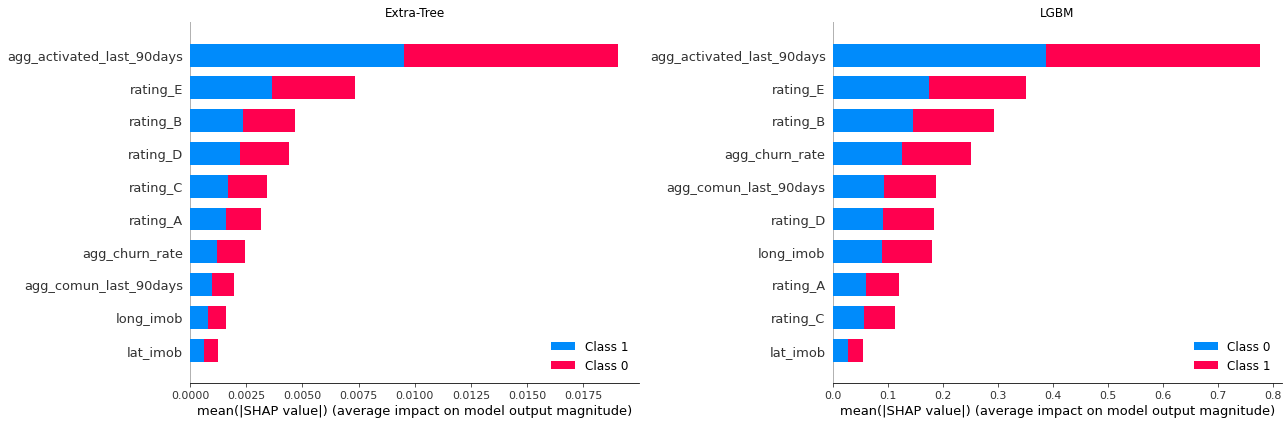

In [14]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
shap_et.summary_plot(plot_type="bar", plot_size=None, show=False)
plt.title("Extra-Tree")

plt.subplot(1,2,2)
shap_lgbm.summary_plot(plot_type="bar", plot_size=None, show=False)
plt.title("LGBM")
plt.tight_layout()
plt.show()

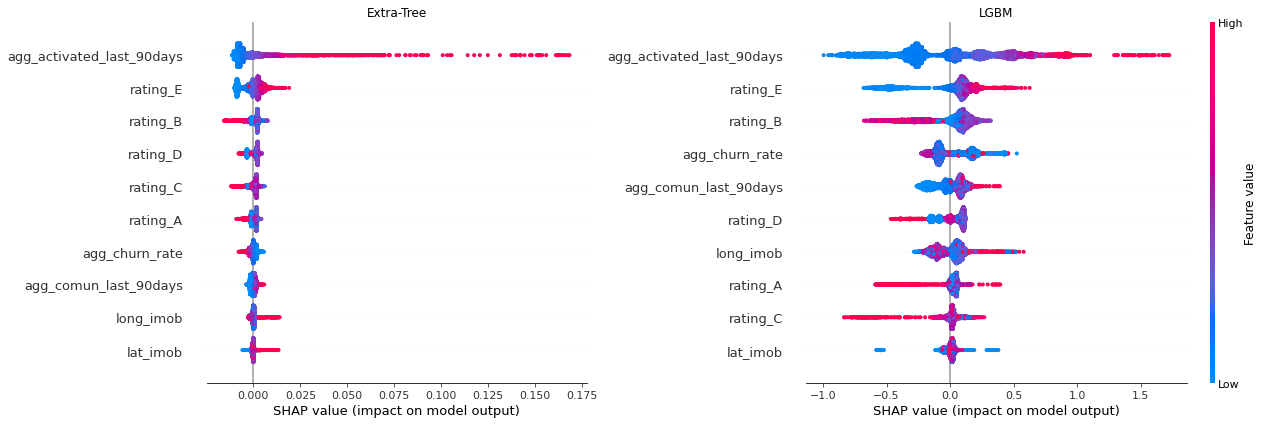

In [15]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
shap_et.summary_plot(plot_size=None, show=False)
plt.title("Extra-Tree")

plt.subplot(1,2,2)
shap_lgbm.summary_plot(plot_size=None, show=False)
plt.title("LGBM")
plt.tight_layout()
plt.show()

In [18]:
# fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22,28))
# shap_et.scatter_plot(["agg_rating_A", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 0], title="Extra-Tree", show=False)
# shap_et.scatter_plot(["agg_rating_B", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 0], show=False)
# shap_et.scatter_plot(["agg_rating_C", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 0], show=False)
# shap_et.scatter_plot(["agg_rating_D", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 0], show=False)
# shap_et.scatter_plot(["agg_rating_E", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 0], show=False)

# shap_lgbm.scatter_plot(["agg_rating_A", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 1], title="LGBM", show=False)
# shap_lgbm.scatter_plot(["agg_rating_B", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 1], show=False)
# shap_lgbm.scatter_plot(["agg_rating_C", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 1], show=False)
# shap_lgbm.scatter_plot(["agg_rating_D", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 1], show=False)
# shap_lgbm.scatter_plot(["agg_rating_E", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 1], show=False)

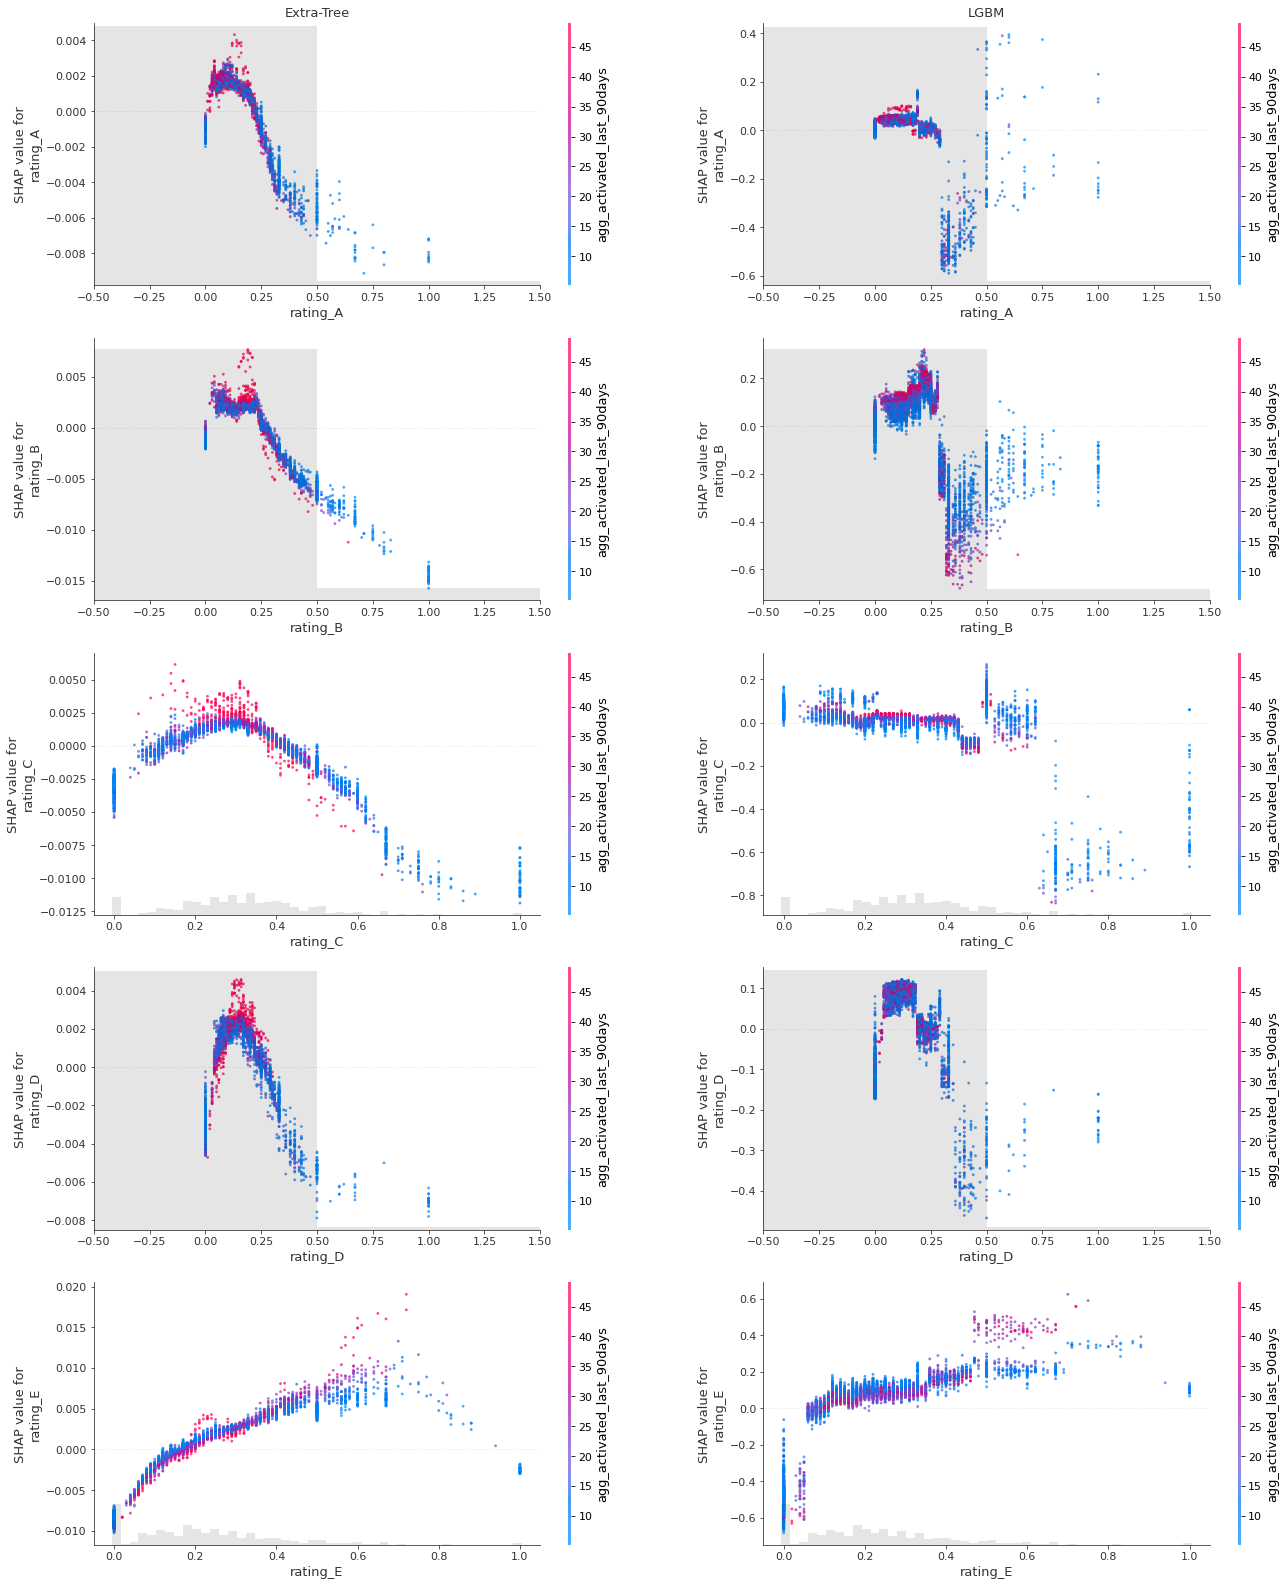

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22,28))
shap_et.scatter_plot(["rating_A", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 0], title="Extra-Tree", show=False)
shap_et.scatter_plot(["rating_B", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 0], show=False)
shap_et.scatter_plot(["rating_C", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 0], show=False)
shap_et.scatter_plot(["rating_D", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 0], show=False)
shap_et.scatter_plot(["rating_E", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 0], show=False)

shap_lgbm.scatter_plot(["rating_A", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 1], title="LGBM", show=False)
shap_lgbm.scatter_plot(["rating_B", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 1], show=False)
shap_lgbm.scatter_plot(["rating_C", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 1], show=False)
shap_lgbm.scatter_plot(["rating_D", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 1], show=False)
shap_lgbm.scatter_plot(["rating_E", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 1], show=False)

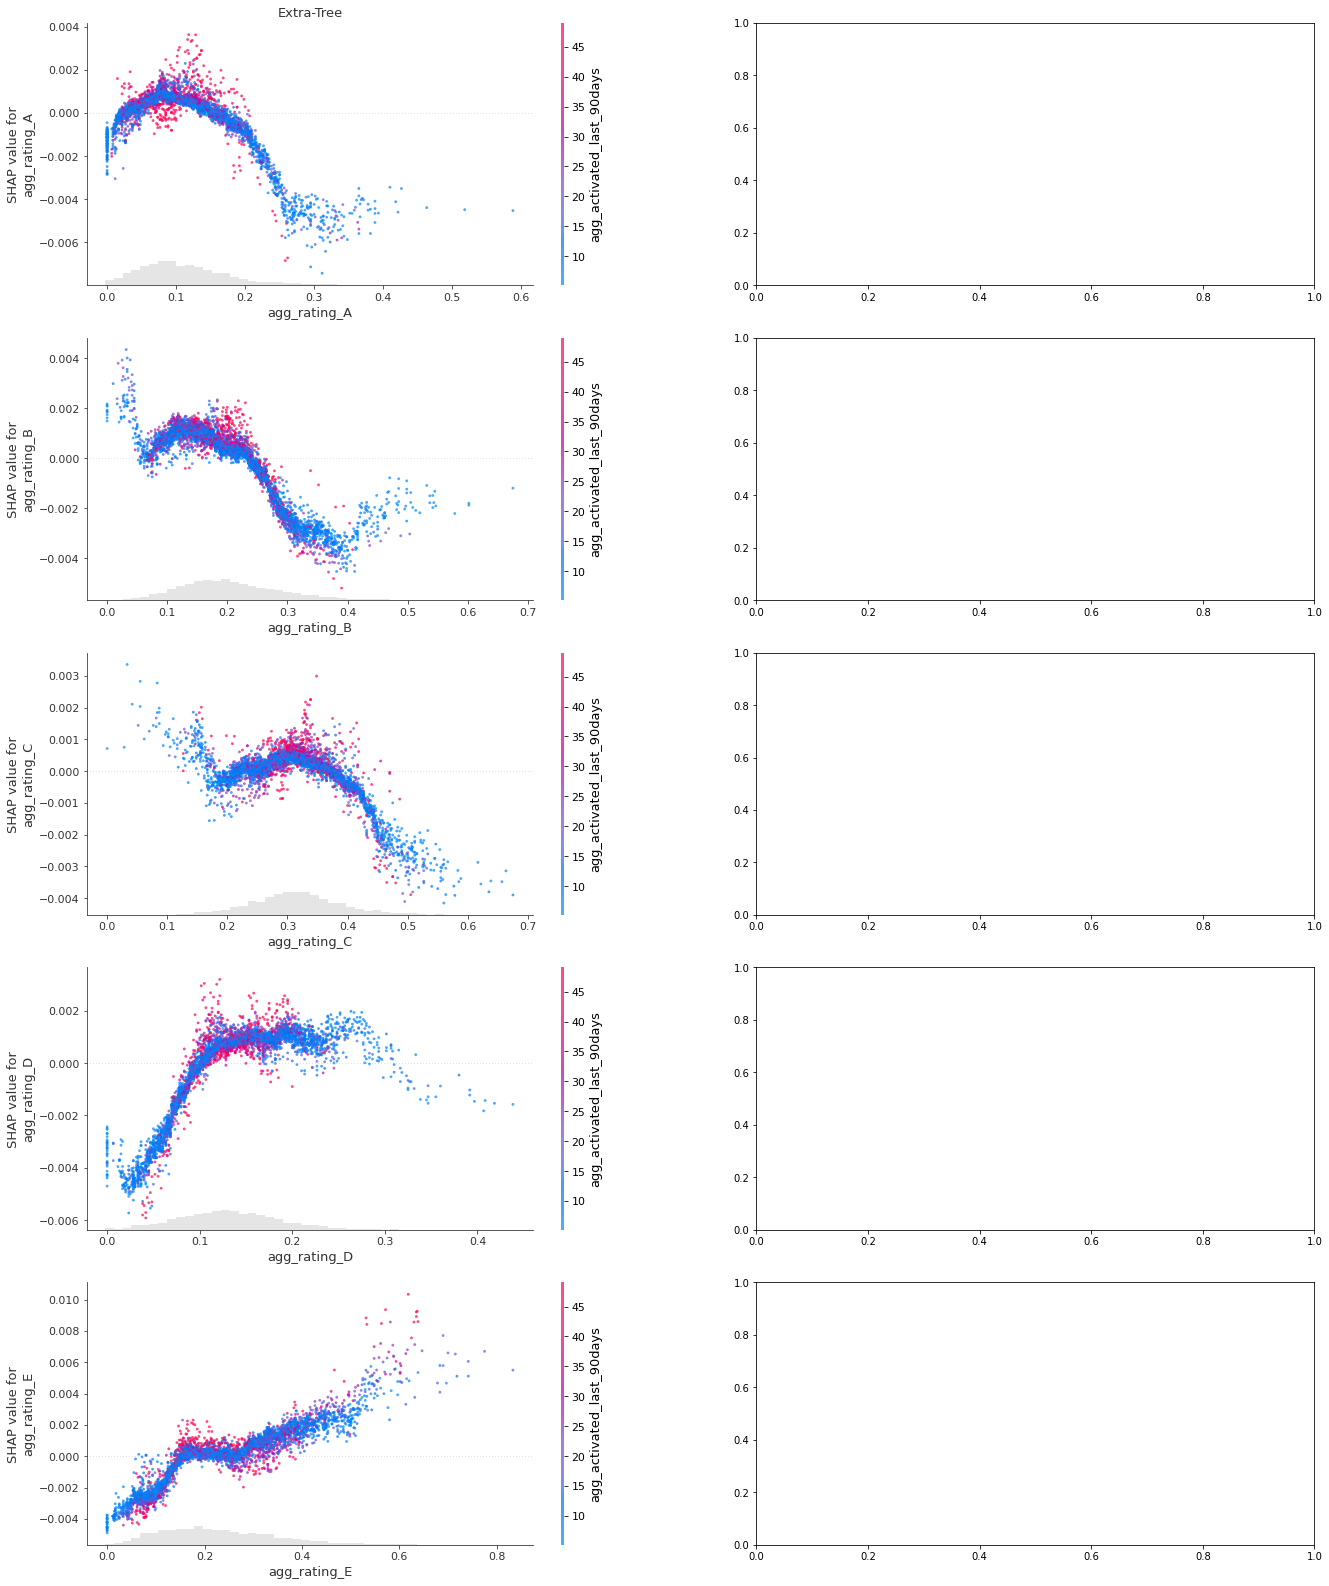

In [19]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22,28))
shap_et.scatter_plot(["agg_rating_A", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 0], title="Extra-Tree", show=False)
shap_et.scatter_plot(["agg_rating_B", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 0], show=False)
shap_et.scatter_plot(["agg_rating_C", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 0], show=False)
shap_et.scatter_plot(["agg_rating_D", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 0], show=False)
shap_et.scatter_plot(["agg_rating_E", "agg_activated_last_90days"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 0], show=False)

# shap_lgbm.scatter_plot(["rating_A", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 1], title="LGBM", show=False)
# shap_lgbm.scatter_plot(["rating_B", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 1], show=False)
# shap_lgbm.scatter_plot(["rating_C", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 1], show=False)
# shap_lgbm.scatter_plot(["rating_D", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 1], show=False)
# shap_lgbm.scatter_plot(["rating_E", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 1], show=False)

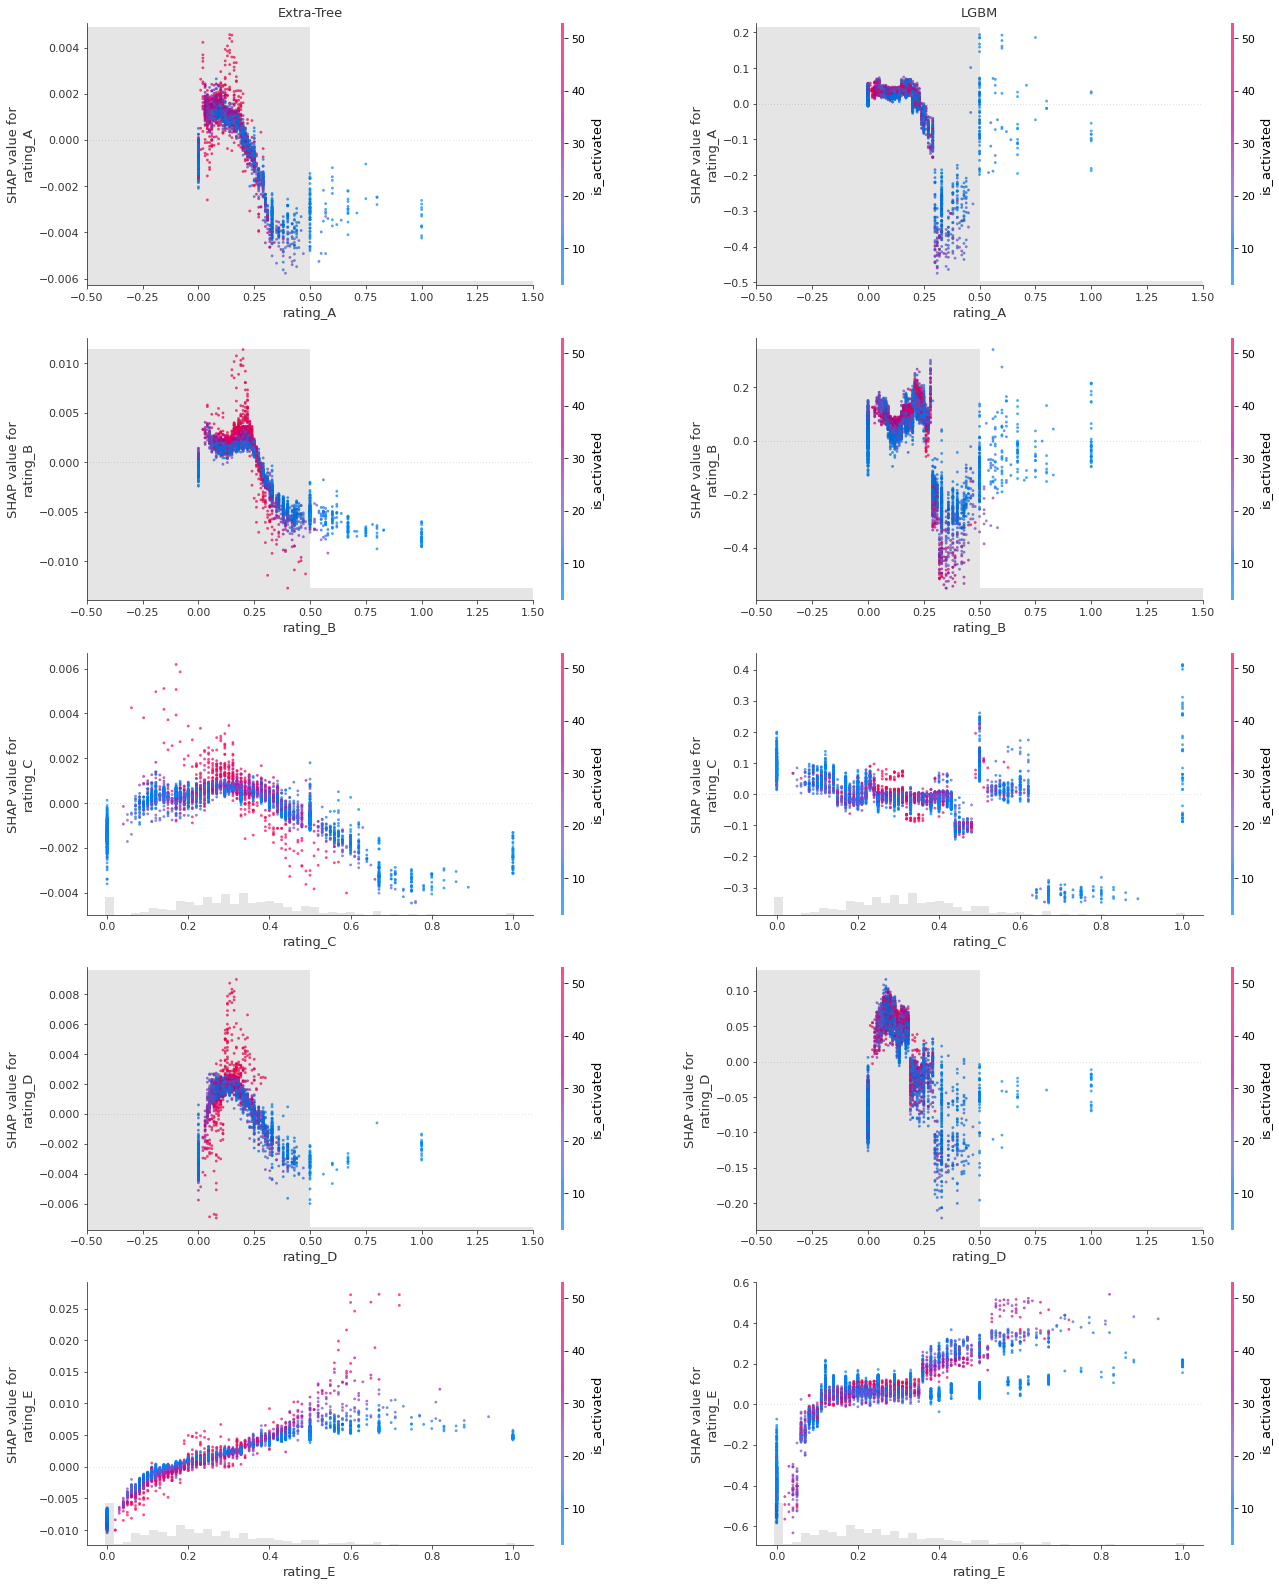

In [17]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22,28))
shap_et.scatter_plot(["rating_A", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 0], title="Extra-Tree", show=False)
shap_et.scatter_plot(["rating_B", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 0], show=False)
shap_et.scatter_plot(["rating_C", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 0], show=False)
shap_et.scatter_plot(["rating_D", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 0], show=False)
shap_et.scatter_plot(["rating_E", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 0], show=False)

shap_lgbm.scatter_plot(["rating_A", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0, 1], title="LGBM", show=False)
shap_lgbm.scatter_plot(["rating_B", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1, 1], show=False)
shap_lgbm.scatter_plot(["rating_C", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[2, 1], show=False)
shap_lgbm.scatter_plot(["rating_D", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[3, 1], show=False)
shap_lgbm.scatter_plot(["rating_E", "is_activated"], dependence=True, dot_size=8, alpha=0.7, ax=axes[4, 1], show=False)

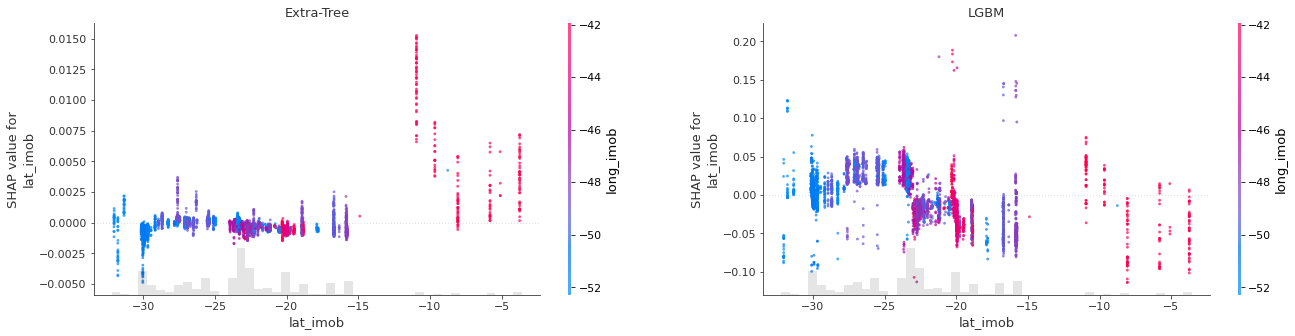

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,5))
shap_et.scatter_plot(["lat_imob", "long_imob"], dependence=True, dot_size=8, alpha=0.7, ax=axes[0], title="Extra-Tree", show=False)
shap_lgbm.scatter_plot(["lat_imob", "long_imob"], dependence=True, dot_size=8, alpha=0.7, ax=axes[1], title="LGBM", show=False)